In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Clustering with Mixtures of Gaussians

## Soft Clustering

We have seen how to cluster objects using $k$-means: 

1. start with an initial set of cluster centers,
2. assign each object to its closest cluster center, and 
3. recompute the centers of the new clusters. 
4. Repeat 2 $\rightarrow$ 3 until convergence.

__Note__ that in $k$-means, every object is assigned to a **single** cluster. 

This is called __hard__ assignment.

However, there may be cases were we either __cannot__ use hard assignments or we do not __want__ to do it! 

In particular, we may believe that the best description of the data is a set of __overlapping__ clusters.

For example: 

Imagine that we believe society consists of just __two__ kinds of individuals: poor, or rich.

Let's think about how we might model society as a mixture of poor and rich, when viewed in terms of age.

<!--image credit: http://autonlab.org/_media/tutorials/gmm14.pdf -->
<center>

<img src="figs/L09-age-wealth-gaussians.png" width="60%">

</center>

Clearly, viewed along the age dimension, there are two clusters that overlap.

Furthermore, given some particular individual at a given age, say 25, we cannot say for sure which cluster they belong to.  

Rather, we will use _probability_ to quantify our uncertainty about the cluster that any single individual belongs to.

Thus, we could say that a given individual ("John Smith", age 25) belongs to the _rich_ cluster with some probability, and the _poor_ cluster with some different probability.

Naturally we expect the probabilities for John Smith to sum up to 1.

This is called __soft assignment,__ and a clustering using this principle is called __soft clustering.__

More formally, we say that an object can belong to each particular cluster with some probability, such that the sum of the probabilities adds up to 1 for each object. 

For example, assuming that we have two clusters $C_1$ and $C_2$, we can have that an object $x_1$ belongs to $C_1$ with probability $0.3$ and to $C_2$ with probability $0.7$.

Note that the distribution over $C_1$ and $C_2$ only refers to object $x_1$.

Thus, it is a __conditional__ probability:

$$P(C_1 \,|\, x_1) = 0.3$$
$$P(C_2 \,|\, x_1) = 0.7$$

And to return to our previous example:

$$P(\text{rich}\,|\,\text{age 25}) + P(\text{poor}\,|\,\text{age 25}) = 1 $$

## Mixtures of Gaussians

We're going to consider a particular model for each cluster: the Gaussian (or Normal) distribution.

$${\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\sigma ^{2}\pi }}}\;exp({-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}})$$

<center>

<img src="figs/L09-Normal_Distribution_PDF.png" width="60%">

</center>

By <a href="//commons.wikimedia.org/wiki/User:Inductiveload" title="User:Inductiveload">Inductiveload</a> - self-made, Mathematica, Inkscape, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=3817954">https://commons.wikimedia.org/w/index.php?curid=3817954</a>

You can see that, for example, this is a reasonable model for the distribution of ages in each of the two population groups (rich and poor).

In the case of the population example, we have a single feature: age.   

How do we use a Guassian when we have multiple features?

The answer is that we use a __multivariate Gaussian.__

<center>

<img src="figs/L09-MultivariateNormal.png" width="70%">

</center>

By <a href="//commons.wikimedia.org/wiki/User:Bscan" title="User:Bscan">Bscan</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/publicdomain/zero/1.0/deed.en" title="Creative Commons Zero, Public Domain Dedication">CC0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=25235145">https://commons.wikimedia.org/w/index.php?curid=25235145</a>

Now each point is a vector in $n$ dimensions: $\vx = (x_1, \dots, x_n)^T$.  

As a reminder, the multivariate Gaussian has a pdf (density) function of:

$$
f(x_{1},\ldots ,x_{n})={\frac  {1}{{\sqrt  {(2\pi )^{{n}}
\Vert{\boldsymbol  \Sigma }\Vert}}}}\exp \left(-{\frac  {1}{2}}({{\mathbf  x}}-{{\boldsymbol  \mu }})^{{\mathrm  {T}}}{{\boldsymbol  \Sigma }}^{{-1}}({{\mathbf  x}}-{{\boldsymbol  \mu }})\right)$$

Recall also that the shape of a multivariate Gaussian -- the direction of its axes and the width along each axis -- is determined by the __covariance matrix $\Sigma$__.

The covariance matrix is the multidimensional analog of the variance.   It determines the extent to which vector components are correlated.

For example, let's say we are looking to classify cars based on their model year and miles per gallon (mpg).  

To illustrate a particular model, let us consider the properties of cars produced in the US, Europe, and Asia.

<!-- image credit: http://autonlab.org/_media/tutorials/gmm14.pdf -->
<center>

<img src="figs/L09-multivariate-example.png" width="90%">

</center>

It seems that the data can be described (roughly) as a mixture of __three__ __multivariate__ Gaussian distributions.

The general situation is that we assume the data was generated according to a collection of arbitrary Gaussian distributions.

This is called a __Gaussian Mixture Model.__

Aka a "GMM".

<!-- image credit: http://autonlab.org/_media/tutorials/gmm14.pdf  and
https://web.iitd.ac.in/~sumeet/GMM_said_crv10_tutorial.pdf -->


<div style = "float: left; width: 45%; text-align: center;">
    <img src="figs/L09-general-GMM.png" width="45%">
    Ellipsoid Representation
</div>
<div style = "float: left; width: 55%; text-align: center;">
    <img src="figs/L09-GMM-density.png"  style="width:55%">
    Density
</div>

A Gaussian Mixture Model is defined by:
    
$$ C_i, \mu_i, \Sigma_i,\;\; i = 1,\dots,k$$

Where $C_i$ is the prior probability (weight) of the $i$th Gaussian, such that 

$$\sum_i C_i = 1,\;\;\; 0\leq C_i\leq 1.$$

Intuitively, $C_i$ tells us "what fraction of the data comes from cluster $i$."

Then the probability density at any point $x$ is given by:
    
$$ p(x) = \sum_i C_i \cdot \mathcal{N}(\mu_i, \Sigma_i) $$

## Learning the Parameters of a GMM

This model is all very well, but how do we learn the parameters of such a model, given some data?

That is, assume we are told there are $k$ clusters.   

For each $i$ in $1, \dots, k$, how do we estimate the 
* cluster probability $C_i$,
* cluster mean $\mu_i$, and 
* cluster covariance  $\Sigma_i$?

There are a variety of ways of finding the best $(C_i, \mu_i, \Sigma_i)\;\;\;i = 1,\dots,k$.

We will consider the most popular method:  __Expectation Maximization (EM).__

This is another famous algorithm, in the same "super-algorithm" league as $k$-means.

EM is formulated using a probabilistic model for data.   It can solve a problem like:

> Given a set of data points and a parameter $k$, find the $(\mu_i, \Sigma_i)\;\;i = 1,\dots,k$ that __maximizes the likelihood of the data__ assuming a GMM with those parameters.

(It can also solve lots of other problems involving maximizing likelihood of data under a model.)

However, note that problems of this type are often NP-hard.  

EM only guarantees that it will find a __local__ optimum of the objective function.

## Probabilities We Will Use

At a high level, EM for the GMM problem has strong similarities to $k$-means.

However, there are two main differences:

1. The $k$-means problem posits a **hard** assignment of objects to clusters, while GMM uses __soft__ assignment.
2. The parameters of the soft assignment are chosed based on a __probability model__ for the data.

Let's start by reviewing the situation probabilistically.

Assume a set data points  $x_1, x_2,\ldots,x_n$ in  a $d$ dimensional space. 

Also assume a set of $k$ clusters $C_1, C_2, \ldots, C_k$.   Each cluster is assumed to follow a Gaussian distribution:

$$ C_i \sim {\mathcal N}({\mathbf \mu_i},{\mathbf \Sigma_i}) $$

We will be working with conditional probabilities:

$P(x_i\,|\,C_j)$ is the probability of seeing data point $x_i$ when sampling from cluster $C_j$.  

That is, it is the value of a Gaussian pdf at the point $x_i$, for a Gaussian with parameters $({\mathbf \mu_j},{\mathbf \Sigma_j})$.

Clearly, if I give you the cluster parameters, it is a straightforward thing to compute this conditional probability.

(Remember: $P(\text{age 25}\,|\,\text{rich})$)

We will also work with $P(C_j\,|\,x_i)$.

This is the probability that a data point at $x_i$ was drawn from cluster $C_j$.   

That is, the data point could have been drawn from any of the $k$ clusters -- what is the probability it was drawn from $C_j$ in particular?

In other words, it is the probability of cluster $C_j$ at point $x_i$.

(Remember: $P(\text{rich}\,|\,\text{age 25})$)

How can we compute $P(C_j\,|\,x_i)$?

Note that the reverse conditional probability is easy to compute -- so this is a job for __Bayes' Rule!__


$$ P(C_j\,|\,x_i)=\frac{P(x_i\,|\,C_j)}{P(x_i)}P(C_j)$$

Finally, we will also need to estimate the parameters of each Gaussian, given some data.

This is also an easy problem.   

For example, the best estimate for the mean of a Gaussian, given some data, is the __average__ of the data points.

Likewise, there is a simple formula for the variance.

These are called __Maximum Likelihood Estimates__ (MLE) of the parameters.

Often we use $\mathbf \theta$ to denote "all the parameters of the model."   In this case $\mathbf \theta_j = ({\mathbf \mu_j},{\mathbf \Sigma_j})$.

## Expectation Maximization for GMM -- The Algorithm

OK, now we have all the necessary pieces.   Here is the algorithm.

__Initialization__: 

Start with an initial set of clusters  $C_1^1, C_2^1, \ldots, C_k^1$ and the initial probabilities that a random point belongs to each cluster $P(C_1), P(C_2), \ldots, P(C_k)$.

The result will be sensitive to this choice, so a good (and fast) initialization procedure is $k$-means.

<!-- Source http://bengio.abracadoudou.com/lectures/gmm.pdf -->

<center>

<img src="figs/L09-EM-E-step.png" width="60%">

</center>

*Step 1* (__Expectation__): For each point $x_i$, compute the probability that it belongs to each cluster $C_j$:

$$ P(C_j\,|\,x_i)=\frac{P(x_i\,|\,C_j)}{P(x_i)}\,P(C_j)$$
    
(Thank you, Rev. Bayes!)

This is called the _posterior_ probability of $C_j$ given $x_i$.

We know how to compute everything on the right.

Note that: $P(x_i) = \sum_{j=1}^k P(x_i\,|\,C_j)\,P(C_j)$

<!-- Source http://bengio.abracadoudou.com/lectures/gmm.pdf -->

<center>

<img src="figs/L09-EM-M-step.png" width="60%">

</center>

*Step 2* __(Maximization)__: Using the cluster membership probabilities computed in the previous step, compute new clusters (parameters) and cluster probabilities.

This is easy, using maximum likelihood estimates of the parameters $\theta$.

$$P(C_j) = \frac{1}{n}\sum_{i=1}^n P(C_j\,|\,x_i)$$

Likewise, compute new parameters for the clusters $C_1, C_2, \ldots, C_n$ using MLE.

__Repeat__ Steps 1 and 2 until stabilization.

Let's pause for a minute and compare GMM/EM with $k$-means.

GMM/EM:

1. Initialize randomly
2. Compute the probability that each point belongs in each cluster
3. Update the clusters (means and variances).
4. Repeat 2-3 until convergence.

$k$-means:

1. Initialize randomly
2. Assign each point to a single cluster
3. Update the clusters (means).
4. Repeat 2-3 until convergence.

From a practical standpoint, the main difference is that in GMM, data points do not belong to a __single__ cluster, but have some probability of belonging to __each__ cluster.

In other words, GMM uses soft assignment.

For that reason, GMM is also sometimes called __soft $k$-means.__

However, there is also an important conceptual difference. 

The GMM starts by making an __explicit assumption__ about how the data were generated.  

It says: "the data came from a collection of multivariate Gaussians."

Note that we made no such assumption when we came up with the $k$-means problem.   In that case, we simply defined an objective function and declared that it was a good one.

Nonetheless, it appears that we were making a sort of Gaussian assumption when we formulated the $k$-means objective function.   However, __we didn't explicitly state it.__

The point is that because the GMM makes its assumptions explicit, we can

* examine them and think about whether they are valid
* replace them with different assumptions if we wish

This sort of assumption is called a "prior" on the data.

Philosophically, __exposing__ this assumption is the heart of Bayesian statistics.

For example, it is perfectly possible to replace the Gaussian assumption with some other probility distribution.   As long as we can estimate the parameters of such distributions from data (eg, have MLEs), we can use EM in that case as well.

## Instantiating EM with the Gaussian Model

If we model each cluster as a multi-dimensional Gaussian, then we can instatiate every part of
the algorithm. 

This is the GMM (Gaussian Mixture Model) algorithm implemented in *sklearn.mixture* module.

In that case $C_i$ is represented by $(\mu_i, \Sigma_i)$ and in EM Step 1 we compute:

$$ P(x_i|C_j) = \frac{1}{\sqrt{(2\pi)^d |\Sigma_j|}} exp (-\frac{1}{2}(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j))$$

In EM Step 2, we estimate the parameters of the Gaussian using the appropriate MLEs:

$$\mu_j'=\frac{\sum_{i=1}^n P(C_j|x_i) x_i}{\sum_{i=1}^n P(C_j|x_i)}$$

and

$$\Sigma_j = \frac{\sum_{i=1}^n P(C_j|x_i) (x_i-\mu_j')(x_i-\mu_j')^T}{\sum_{i=1}^n P(C_j|x_i)}$$

A final statement about EM generally.   EM is a versatile algorithm that can be used in many other settings.  What is the main idea behind it?

Notice that the problem definition only required that we find the clusters, $C_i$, meaning that we were to find the $(\mu_i, \Sigma_i)$.

However, the EM algorithm posited that we should find as well the $P(C_j|x_i)$, that is, the probability that each point is a member of each cluster.

This is the true heart of what EM does.   

The idea is called "data augmentation."

By __adding parameters__ to the problem, it actually finds a way to make the problem solvable!

These parameters don't show up in the solution.  They are sometimes called "hidden parameters."

So the basic strategy for using EM is: think up some __additional__ information which, if you had it, would make the problem solvable.

Figure out how to estimate the additional information from a solved problem, and put the two steps into a loop.

Here is an example using **GMM**.

In [2]:
import time
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

import seaborn as sns

# Number of samples per component
n_samples = 1000

# Generate random sample, two components
np.random.seed(0)
# C is a transfomation that will make a heavily skewed 2-D Gaussian
C = np.array([[0.1, -0.1], [1.7, .4]])
print(C.T@C)

[[2.9  0.67]
 [0.67 0.17]]


In [3]:
# now we construct a data matrix that has n_samples from the skewed distribution,
# and n_samples from a symmetric distribution offset to position (-6,3)
X = np.r_[(np.random.randn(n_samples, 2) @ C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
print(X[:10])

[[ 0.85667249 -0.01634235]
 [ 3.90739224  0.79848348]
 [-1.4746166  -0.57766695]
 [-0.16229841 -0.15555173]
 [ 0.68769557  0.17456129]
 [ 2.48666932  0.56730505]
 [ 0.2829513  -0.02743377]
 [ 0.61163268  0.08908341]
 [-0.19936114 -0.23147121]
 [-1.42065599 -0.37294507]]


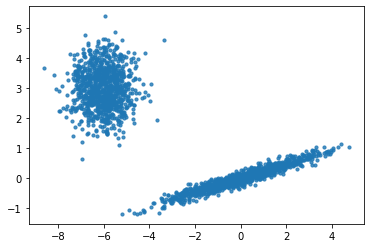

In [4]:
_ = plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)

In [5]:
# Fit a mixture of Gaussians with EM using two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')

gmm.fit(X)

y_pred = gmm.predict(X)

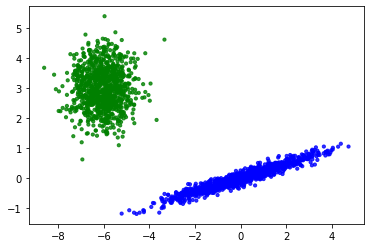

In [6]:
colors = ['bg'[p] for p in y_pred]
_ = plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, alpha=0.8)

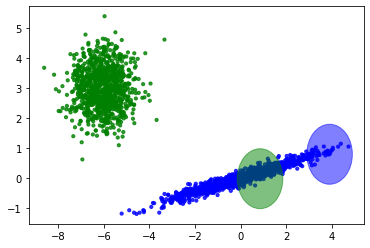

In [7]:
colors = ['bg'[p] for p in y_pred]
_ = plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, alpha=0.8)
circle1 = plt.Circle(X[0,:], 1, color='g', alpha = 0.5)
circle2 = plt.Circle(X[1,:], 1, color='b', alpha = 0.5)
ax=plt.gcf().gca()
ax.add_artist(circle1)
ax.add_artist(circle2)

In [8]:
fig = plt.figure()


<Figure size 432x288 with 0 Axes>

Now, let's construct __overlapping__ clusters.  What will happen?

In [9]:
X = np.r_[np.random.randn(n_samples, 2) @ C,
          0.7 * np.random.randn(n_samples, 2) ]

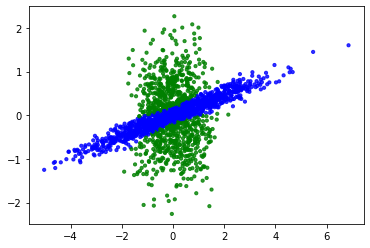

In [10]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
y_pred = gmm.predict(X)
colors = ['bgrky'[p] for p in y_pred]
_ = plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, alpha=0.8)

In [11]:
gmm.means_

array([[ 0.03696179,  0.00576342],
       [ 0.0061901 , -0.00266004]])

In [12]:
gmm.covariances_

array([[[ 2.85108611,  0.65945951],
        [ 0.65945951,  0.16841863]],

       [[ 0.50201377, -0.01338318],
        [-0.01338318,  0.53549045]]])

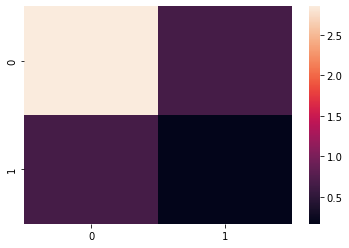

In [13]:
_ = sns.heatmap(gmm.covariances_[0])

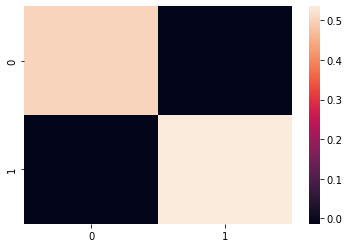

In [14]:
_ = sns.heatmap(gmm.covariances_[1])

## How many parameters are estimated?

Most of the parameters in the model are contained in the covariance matrices.

In the most general case, for $k$ clusters of points in $n$ dimensions, there are $k$ covariance matrices each of size $n \times n$.   

So we need $kn^2$ parameters to specify this model.

It can happen that you may not have enough data to estimate so many parameters.

Also, it can happen that you believe that clusters should have some constraints on their shapes.

Here is where the GMM assumptions become __really__ useful.

Let's say you believe all the clusters should have the same shape, but the shape can be arbitrary. 

Then you only need to estimate __one__ covariance matrix - just $n^2$ parameters.

This is specified by the GMM parameter `covariance_type='tied'`.

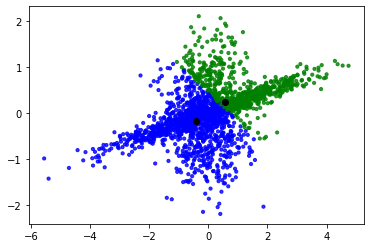

In [15]:
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          0.7 * np.random.randn(n_samples, 2) ]
gmm = mixture.GaussianMixture(n_components=2, covariance_type='tied')
gmm.fit(X)
y_pred = gmm.predict(X)
colors = ['bgrky'[p] for p in y_pred]
plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, alpha=0.8)
_ = plt.plot(gmm.means_[:,0],gmm.means_[:,1],'ok')

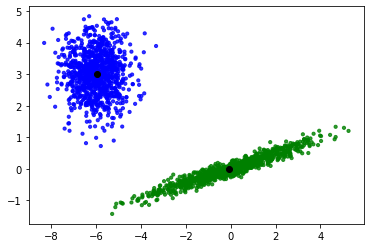

In [16]:
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          0.7 * np.random.randn(n_samples, 2) + np.array([-6,3])]
gmm = mixture.GaussianMixture(n_components=2, covariance_type='tied')
gmm.fit(X)
y_pred = gmm.predict(X)
colors = ['bgrky'[p] for p in y_pred]
plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, alpha=0.8)
_ = plt.plot(gmm.means_[:,0],gmm.means_[:,1],'ok')

Perhaps you believe in even more restricted shapes: all clusters should have their axes aligned with the coordinate axes.

That is, clusters are not skewed.


Then you only need to estimate the diagonals of the covariance matrices - just $kn$ parameters.

This is specified by the GMM parameter `covariance_type='diag'`.

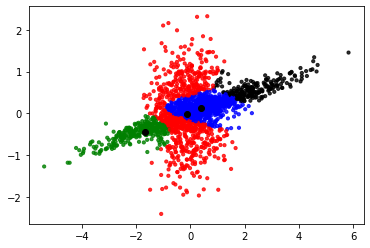

In [17]:
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          0.7 * np.random.randn(n_samples, 2)]
gmm = mixture.GaussianMixture(n_components=4, covariance_type='diag')
gmm.fit(X)
y_pred = gmm.predict(X)
colors = ['bgrky'[p] for p in y_pred]
plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, alpha=0.8)
_ = plt.plot(gmm.means_[:,0],gmm.means_[:,1],'ok')

Finally, if you believe that all clusters should be round, then you only need to estimate the $k$ variances.  

This is specified by the GMM parameter `covariance_type='spherical'`.

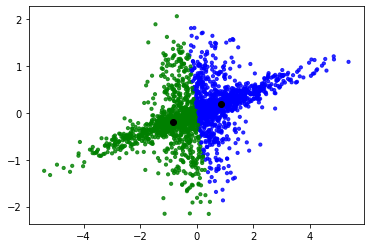

In [18]:
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          0.7 * np.random.randn(n_samples, 2)]
gmm = mixture.GaussianMixture(n_components=2, covariance_type='spherical')
gmm.fit(X)
y_pred = gmm.predict(X)
colors = ['bgrky'[p] for p in y_pred]
plt.scatter(X[:, 0], X[:, 1], color=colors, s=10, alpha=0.8)
_ = plt.plot(gmm.means_[:,0],gmm.means_[:,1],'ok')